In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import json


In [2]:
!wget 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/All_Beauty.jsonl.gz'

--2024-04-26 05:21:19--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/All_Beauty.jsonl.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95357493 (91M) [application/x-gzip]
Saving to: ‘All_Beauty.jsonl.gz’

All_Beauty.jsonl.gz 100%[===================>]  90.94M   826KB/s    in 1m 46s  

2024-04-26 05:23:12 (883 KB/s) - ‘All_Beauty.jsonl.gz’ saved [95357493/95357493]



In [ ]:
!wget 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/meta_categories/meta_All_Beauty.jsonl.gz'

--2024-04-26 05:24:02--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/meta_categories/meta_All_Beauty.jsonl.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40415458 (39M) [application/x-gzip]
Saving to: ‘meta_All_Beauty.jsonl.gz’

meta_All_Beauty.jso   3%[                    ]   1.29M   411KB/s    eta 93s    

In [2]:
!gunzip All_Beauty.jsonl.gz

gzip: All_Beauty.jsonl.gz: No such file or directory


In [3]:
!gunzip meta_All_Beauty.jsonl.gz

gzip: meta_All_Beauty.jsonl.gz: No such file or directory


In [6]:
df_ratings = pd.read_json('All_Beauty.jsonl',lines=True)

In [11]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             701528 non-null  int64         
 1   title              701528 non-null  object        
 2   text               701528 non-null  object        
 3   images             701528 non-null  object        
 4   asin               701528 non-null  object        
 5   parent_asin        701528 non-null  object        
 6   user_id            701528 non-null  object        
 7   timestamp          701528 non-null  datetime64[ns]
 8   helpful_vote       701528 non-null  int64         
 9   verified_purchase  701528 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 48.8+ MB


In [7]:
df_meta = pd.read_json('meta_All_Beauty.jsonl',lines = True)

In [12]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112590 entries, 0 to 112589
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   main_category    112590 non-null  object 
 1   title            112590 non-null  object 
 2   average_rating   112590 non-null  float64
 3   rating_number    112590 non-null  int64  
 4   features         112590 non-null  object 
 5   description      112590 non-null  object 
 6   price            17704 non-null   float64
 7   images           112590 non-null  object 
 8   videos           112590 non-null  object 
 9   store            101259 non-null  object 
 10  categories       112590 non-null  object 
 11  details          112590 non-null  object 
 12  parent_asin      112590 non-null  object 
 13  bought_together  0 non-null       float64
dtypes: float64(3), int64(1), object(10)
memory usage: 12.0+ MB


In [26]:
# prompt: print first 5 values from df_meta details column

print(df_meta['details'].head(10))


0    {'Package Dimensions': '7.1 x 5.5 x 3 inches; ...
1    {'Item Form': 'Powder', 'Skin Type': 'Acne Pro...
2           {'Manufacturer': 'Levine Health Products'}
3    {'Brand': 'Cherioll', 'Item Form': 'Powder', '...
4                              {'UPC': '644287689178'}
5    {'Color': 'As Shown', 'Size': 'Large', 'Materi...
6    {'Brand': 'Edoneery', 'Material': 'Silk', 'Num...
7    {'Package Dimensions': '14.49 x 11.26 x 2.36 i...
8    {'Brand': 'Balmain', 'Item Form': 'Spray', 'It...
9    {'Package Dimensions': '12.49 x 9.97 x 1.46 in...
Name: details, dtype: object


In [8]:
# prompt: merge df_ratings and df_meta on parent_asin

df_merged = pd.merge(df_ratings, df_meta, on='parent_asin')


In [28]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             701528 non-null  int64         
 1   title_x            701528 non-null  object        
 2   text               701528 non-null  object        
 3   images_x           701528 non-null  object        
 4   asin               701528 non-null  object        
 5   parent_asin        701528 non-null  object        
 6   user_id            701528 non-null  object        
 7   timestamp          701528 non-null  datetime64[ns]
 8   helpful_vote       701528 non-null  int64         
 9   verified_purchase  701528 non-null  bool          
 10  main_category      701528 non-null  object        
 11  title_y            701528 non-null  object        
 12  average_rating     701528 non-null  float64       
 13  rating_number      701528 non-null  int64   

In [9]:
# prompt: only keep user_id , parent_asin, average_rating, rating_number, price, store, rating columns of df_merged

df = df_merged[['user_id', 'parent_asin', 'average_rating', 'rating_number', 'price', 'store', 'rating']]


In [30]:
df.head()

,user_id,parent_asin,average_rating,rating_number,price,store,rating
0,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B00YQ6X8EO,4.3,384,NaN,HERBIVORE,5
1,AGF2RF5HBCXKEOLTF2LXZTVFYFVQ,B00YQ6X8EO,4.3,384,NaN,HERBIVORE,1
2,AGPWM36OKQCL3PM4MXZNLP4VVJKA,B00YQ6X8EO,4.3,384,NaN,HERBIVORE,5
3,AGVVMZD2DJQ7Z3KJJXHFKQHSX7HA,B00YQ6X8EO,4.3,384,NaN,HERBIVORE,5
4,AE5VLXANR3ZCUZCQAOBJTIEGMZGA,B00YQ6X8EO,4.3,384,NaN,HERBIVORE,2


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         701528 non-null  object 
 1   parent_asin     701528 non-null  object 
 2   average_rating  701528 non-null  float64
 3   rating_number   701528 non-null  int64  
 4   price           185623 non-null  float64
 5   store           651636 non-null  object 
 6   rating          701528 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 37.5+ MB


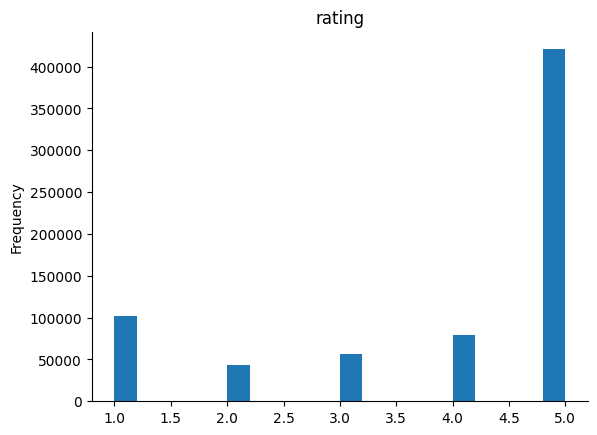

In [32]:
from matplotlib import pyplot as plt
df['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

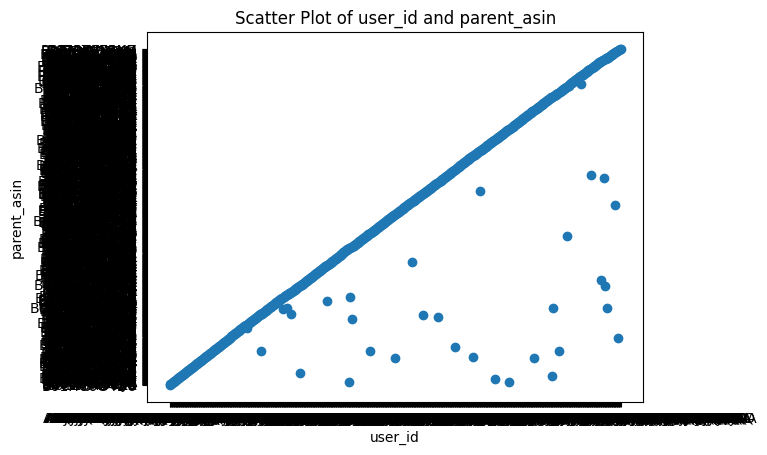

In [36]:
# prompt: plot scatter plot of user_id and asin
sampled_df = df.sample(frac=0.001)  # Adjust the fraction as needed
plt.scatter(sampled_df['user_id'], sampled_df['parent_asin'])
plt.xlabel('user_id')
plt.ylabel('parent_asin')
plt.title('Scatter Plot of user_id and parent_asin')
plt.show()


In [41]:
sampled_df.head()


,user_id,parent_asin,average_rating,rating_number,price,store,rating
226854,AFQPZUB265GZKEZUJT5H6AE25KIA,B01HC6G4D6,4.3,158,NaN,Mosher Salon Tools,5
96936,AHBFMY4GTZV5KN4UI6XFFO3SXFTA,B01E3MF6KE,4.0,378,NaN,Esarora,5
534334,AEG6IL2M4J66IPTYDK7UP23ECIOA,B071VMDYZR,4.4,62,NaN,Beyond Beauty,3
168569,AGJ5ABV5HPGI7XBNQ44S356JGWPQ,B07WH7675C,3.9,781,5.99,Lunana Beauty,5
378823,AE3J4AARTEBT4LXTCZ6XHJCRDSTQ,B00RYB7BJG,3.0,12,NaN,None,1


from matplotlib import pyplot as plt
_df_0['average_rating'].plot(kind='hist', bins=20, title='average_rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['rating_number'].plot(kind='hist', bins=20, title='rating_number')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['price'].plot(kind='hist', bins=20, title='price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('user_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('parent_asin').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('store').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='average_rating', y='rating_number', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='rating_number', y='price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='price', y='rating', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['average_rating'].plot(kind='line', figsize=(8, 4), title='average_rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['rating_number'].plot(kind='line', figsize=(8, 4), title='rating_number')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['price'].plot(kind='line', figsize=(8, 4), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['parent_asin'].value_counts()
    for x_label, grp in _df_14.groupby('user_id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('user_id')
_ = plt.ylabel('parent_asin')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['store'].value_counts()
    for x_label, grp in _df_15.groupby('parent_asin')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('parent_asin')
_ = plt.ylabel('store')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['user_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='average_rating', y='user_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['parent_asin'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='average_rating', y='parent_asin', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['store'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='average_rating', y='store', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['user_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='rating_number', y='user_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['parent_asin'].value_counts()
    for x_label, grp in _df_14.groupby('user_id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('user_id')
_ = plt.ylabel('parent_asin')

In [37]:
import seaborn as sns

<Axes: xlabel='parent_asin', ylabel='rating'>

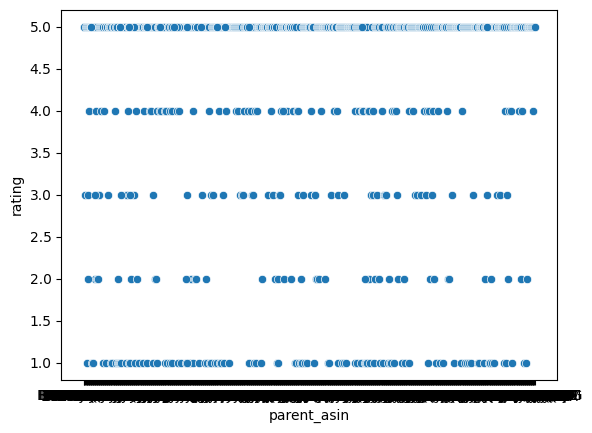

In [40]:
sns.scatterplot(data=sampled_df,x='parent_asin',y='rating')

In [ ]:
# prompt: get all the unique values for the asin and parent_asin columns

asin_unique = df['asin'].unique()
parent_asin_unique = df['parent_asin'].unique()


In [ ]:
df['asin'].nunique()

115709

In [ ]:
df = df.drop(['title','text','images','timestamp'],axis=1)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         701528 non-null  object 
 1   parent_asin     701528 non-null  object 
 2   average_rating  701528 non-null  float64
 3   rating_number   701528 non-null  int64  
 4   price           185623 non-null  float64
 5   store           651636 non-null  object 
 6   rating          701528 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 37.5+ MB


In [ ]:
# Load JSON data into DataFrame
with open('All_Beauty.jsonl', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)


In [15]:
# Define categorical features and their vocabularies
categorical_features = ['user_id', 'parent_asin']
categorical_vocab_sizes = [df[cat].nunique() for cat in categorical_features]

In [44]:
print(categorical_vocab_sizes)

[631986, 112565, 30757]


In [20]:



for col in categorical_features:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

# Define numerical features
numerical_features = ['average_rating','rating_number','price']
print(categorical_features, numerical_features)
df.info()
# Combine all features
all_features = categorical_features


# Split data into features and target
X = df[all_features]
y = df['rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize numerical features
# scaler = StandardScaler()
# X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
# X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# X_train[numerical_features] = X_train[numerical_features]
# X_test[numerical_features] = X_test[numerical_features]


# Create embedding layers for categorical features
embedding_layers = []
input_layers = []
reduction_factor = 128 * 24
for i, cat in enumerate(categorical_features):
    input_layer = Input(shape=(1,), name=cat)
    embedding_layer = Embedding(input_dim=categorical_vocab_sizes[i] + 1, output_dim=int(categorical_vocab_sizes[i]/reduction_factor)+1)(input_layer)
    embedding_layer = Flatten()(embedding_layer)  # Flatten the embeddings
    embedding_layers.append(embedding_layer)
    input_layers.append(input_layer)

# for i, num in enumerate(numerical_features):
#     num_layer = Input(shape=(1,), name=num)
#     input_layers.append(num_layer)
#     embedding_layers.append(num_layer)
# print(input_layers)

# Concatenate all input embeddings and numerical features
concatenated_inputs = concatenate(embedding_layers )



<ipython-input-20-fe457f1d991f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = encoder.fit_transform(df[col])
<ipython-input-20-fe457f1d991f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = encoder.fit_transform(df[col])


['user_id', 'parent_asin'] ['average_rating', 'rating_number', 'price']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         701528 non-null  int64  
 1   parent_asin     701528 non-null  int64  
 2   average_rating  701528 non-null  float64
 3   rating_number   701528 non-null  int64  
 4   price           185623 non-null  float64
 5   store           701528 non-null  int64  
 6   rating          701528 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 37.5 MB


In [21]:
# Build MLP model
dense_layer = Dense(128, activation='relu')(concatenated_inputs)
dense_layer = Dropout(0.3)(dense_layer)
dense_layer = Dense(128, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)
output_layer = Dense(6, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=input_layers , outputs=output_layer)
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 parent_asin (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 1, 206)               1301893   ['user_id[0][0]']             
                                                          22                                      
                                                                                                  
 embedding_6 (Embedding)     (None, 1, 37)                4164942   ['parent_asin[0][0]']   

In [ ]:

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=5,
                   restore_best_weights=True)

# Train the model
history = model.fit([X_train[cat].values for cat in all_features] ,
          y_train,
          validation_data=([X_test[cat].values for cat in all_features], y_test),
          epochs=100,
          batch_size=128,callbacks=[es])

Epoch 1/100
 484/4933 [=>............................] - ETA: 4:37:01 - loss: 1.2406 - accuracy: 0.5988

In [13]:
# prompt: print first few values of x_train

print(X_train.head())


        user_id  parent_asin  store  average_rating  rating_number  price
72400    514790        25022  23764             4.2             63    NaN
428569    89541        18008  18780             3.8             62    NaN
385316   153546        27762  15541             3.5             47    NaN
13368    205194         6522  13524             4.8            879  16.99
632034    81368        93840  20349             3.9             43    NaN
